In [1]:
from sklearn.preprocessing import scale
from h2o.automl import H2OAutoML
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import H2ONaiveBayesEstimator
from sklearn.metrics import confusion_matrix
from google.cloud import bigquery # modulo para interactuar con la API y el service account del DW
import pandas as pd
import numpy as np
import h2o
import datetime
inicio = datetime.datetime.now()


In [2]:
%matplotlib inline
# un bonita funcion para hacer los querys 
def query_BQ(query_string):
    client = bigquery.Client() # inicializamos el cliente, pero antes se debe de fijar la variable de entorno 
    query_job = client.query(query_string)
    results = query_job.result().to_dataframe()  # Waits for job to complete and cast to pandas dataframe
    return(results)

# la consulta
string = '''
SELECT user_id, language, mp_region, country, city, signup_provider, timezone, user_gender, email_domain, os,
adjust_network, baby_gender, weeks_before_birth, baby_age_at_signup_meses, edad_bebe_actual_meses, 
IF ( date_diff(premium_conversion_date, signup_date, day) > 0, 'Premium', 'Freemium') as did_convert
FROM `celtic-music-240111.dbt_prod_base.ba_predictive_demographics` as A
WHERE country='US'
AND os='iOS'

'''
raw_data = query_BQ(string) # ejecucion de la consulta 

In [3]:
fin = datetime.datetime.now()
print(fin-inicio)

0:00:34.178182


In [4]:
raw_data['did_convert'].value_counts()

Freemium    166327
Premium       4829
Name: did_convert, dtype: int64

In [5]:
raw_data.describe()

user_id  weeks_before_birth  baby_age_at_signup_meses  \
count  1.711560e+05       171156.000000             171156.000000   
mean   3.261568e+06           38.416848                  3.518983   
std    5.393391e+05            2.358057                  5.494148   
min    2.451443e+06            0.000000                -10.000000   
25%    2.762145e+06           37.000000                  1.000000   
50%    3.249364e+06           39.000000                  2.000000   
75%    3.706028e+06           40.000000                  4.000000   
max    4.332554e+06           44.000000                 46.000000   

       edad_bebe_actual_meses  
count           171156.000000  
mean                12.145902  
std                  6.600294  
min                  0.000000  
25%                  8.000000  
50%                 11.000000  
75%                 14.000000  
max                 48.000000

In [6]:
raw_data.columns

Index(['user_id', 'language', 'mp_region', 'country', 'city',
       'signup_provider', 'timezone', 'user_gender', 'email_domain', 'os',
       'adjust_network', 'baby_gender', 'weeks_before_birth',
       'baby_age_at_signup_meses', 'edad_bebe_actual_meses', 'did_convert'],
      dtype='object')

In [7]:
raw_data.shape

(171156, 16)

In [8]:
print(raw_data.shape)
raw_data = raw_data.drop_duplicates()

(171156, 16)


In [9]:
raw_data.shape

(171156, 16)

In [10]:
raw_data = raw_data.dropna()
raw_data.shape

(171156, 16)

In [11]:
raw_data.describe()
# raw_data['user_age'].plot.kde()

user_id  weeks_before_birth  baby_age_at_signup_meses  \
count  1.711560e+05       171156.000000             171156.000000   
mean   3.261568e+06           38.416848                  3.518983   
std    5.393391e+05            2.358057                  5.494148   
min    2.451443e+06            0.000000                -10.000000   
25%    2.762145e+06           37.000000                  1.000000   
50%    3.249364e+06           39.000000                  2.000000   
75%    3.706028e+06           40.000000                  4.000000   
max    4.332554e+06           44.000000                 46.000000   

       edad_bebe_actual_meses  
count           171156.000000  
mean                12.145902  
std                  6.600294  
min                  0.000000  
25%                  8.000000  
50%                 11.000000  
75%                 14.000000  
max                 48.000000

In [12]:
raw_data['did_convert'].value_counts()

Freemium    166327
Premium       4829
Name: did_convert, dtype: int64

In [13]:
numerics = [ 'weeks_before_birth', 'baby_age_at_signup_meses', 'edad_bebe_actual_meses']
categorics = [ i for i in raw_data.columns if i not in numerics]
categorics

['user_id',
 'language',
 'mp_region',
 'country',
 'city',
 'signup_provider',
 'timezone',
 'user_gender',
 'email_domain',
 'os',
 'adjust_network',
 'baby_gender',
 'did_convert']

In [14]:
X = scale(raw_data[numerics])
X = pd.DataFrame(X)
X.columns = numerics
X2 = raw_data[categorics]

/root/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [15]:
print(X2.columns)
X.columns

Index(['user_id', 'language', 'mp_region', 'country', 'city',
       'signup_provider', 'timezone', 'user_gender', 'email_domain', 'os',
       'adjust_network', 'baby_gender', 'did_convert'],
      dtype='object')


Index(['weeks_before_birth', 'baby_age_at_signup_meses',
       'edad_bebe_actual_meses'],
      dtype='object')

In [16]:
X = pd.concat( [X2.reset_index(drop=True), X  ], axis = 1)

In [17]:
X.columns

Index(['user_id', 'language', 'mp_region', 'country', 'city',
       'signup_provider', 'timezone', 'user_gender', 'email_domain', 'os',
       'adjust_network', 'baby_gender', 'did_convert', 'weeks_before_birth',
       'baby_age_at_signup_meses', 'edad_bebe_actual_meses'],
      dtype='object')

In [18]:
h2o.init(min_mem_size = 200)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)
  Starting server from /root/anaconda3/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpc2durkjz
  JVM stdout: /tmp/tmpc2durkjz/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpc2durkjz/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         04 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.26.0.1
H2O cluster version age:    6 months and 21 days !!!
H2O cluster name:           H2O_from_python_unknownUser_za92wa
H2O cluster total nodes:    1
H2O cluster free memory:    200 Gb
H2O cluster total cores:    70
H2O cluster allowed cores:  70
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.5.6 final
--------------------------  ---------------------------------------------------

In [19]:
X_hf = h2o.H2OFrame(X)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [20]:
X_hf.types
type(X_hf)

h2o.frame.H2OFrame

In [21]:
train, test = X_hf.split_frame(ratios = [.7], seed=0)

In [22]:
X_hf.describe()

Rows:171156
Cols:16




user_id language mp_region country city signup_provider timezone user_gender email_domain os adjust_network baby_gender did_convert weeks_before_birth baby_age_at_signup_meses edad_bebe_actual_meses 
 
 
 type int enum enum enum enum enum enum enum enum enum enum enum enum real real real 
 mins 2451443.0 -16.29178857285202 -2.460622061623689 -1.8402115204210905 
 mean 3261568.2416742607 -1.509129071160296e-15 8.077028831562148e-16 -1.7004271224341363e-16 
 maxs 4332554.0 2.367699086354676 7.732070590439121 5.432212799768988 
 sigma 539339.083075659 1.000002921324353 1.000002921324353 1.0000029213243544 
 zeros 0 0 0 0 
 missing 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
 0 2522460.0 en Michigan US Tampa Kinedu America/Detroit female yahoo.com iOS FACEBOOK male Freemium -0.6008557685191169 3.5457861083418956 3.614106719721468 
 1 3506147.0 es Santiago Metropolitan US Santiago Facebook America/Santiago female hotmail.com iOS FACEBOOK female Freemium -0.6008557685191169 4.455847952276075 3.4625978797175083 
 2 2730534.0 en Arizona US Los Angeles Facebook America/Phoenix female gmail.com iOS FACEBOOK female Freemium 0.2473027614448238 4.637860321062911 4.371650919741268 
 3 3052813.0 en Hawaii US Kaneohe Kinedu Pacific/Honolulu female hotmail.com iOS FACEBOOK female Freemium 0.2473027614448238 5.183897427423418 4.523159759745228 
 4 3350220.0 en Hawaii US Honolulu Kinedu Pacific/Honolulu female yahoo.com iOS FACEBOOK female Freemium 1.0954612914087645 5.183897427423418 4.220142079737308 
 5 3160626.0 pt Alagoas US Maceió Facebook America/Maceio female hotmail.com iOS FACEBOOK male Freemium 0.2473027614448238 6.093959271357598 5.129195119761068 
 6 2521667.0 en Indiana US Center Line Facebook America/Indiana/Indianapolis female gmail.com iOS FACEBOOK male Freemium -0.6008557685191169 4.819872689849747 4.674668599749188 
 7 2579807.0 en Indiana US Sellersburg Facebook America/Indianapolis female aol.com iOS FACEBOOK female Freemium 0.2473027614448238 3.3637737395550595 3.4625978797175083 
 8 4064762.0 en Arizona US Avondale Facebook America/Phoenix female gmail.com iOS FACEBOOK female Freemium 0.2473027614448238 -1.186535480115838 -1.6887026804171303 
 9 3829239.0 en Arizona US Tucson Kinedu America/Phoenix female yahoo.com iOS FACEBOOK male Freemium 1.519540556390735 4.637860321062911 3.3110890397135484

In [23]:
gbm = H2OGradientBoostingEstimator(model_id = "AntonioUSgbm", seed = 0, balance_classes=True,  nfolds = 10)
gbm.train(  x= ['language', 'mp_region', 'city', 'signup_provider', 'timezone', 'user_gender',
               'email_domain', 'adjust_network', 'baby_gender', 'weeks_before_birth', 
               'baby_age_at_signup_meses', 'edad_bebe_actual_meses'], y='did_convert', training_frame=train)
y = gbm.predict(test)
y = y['predict'].as_data_frame()
y_hat = test['did_convert'].as_data_frame()

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


In [24]:
gbm.model_performance(test)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.02776243527392039
RMSE: 0.16662063279774322
LogLoss: 0.12929081047007826
Mean Per-Class Error: 0.41760000693921717
AUC: 0.615750260865708
pr_auc: 0.047264222889357006
Gini: 0.2315005217314161
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.045399750878017044: 


Freemium    Premium    Error    Rate
--------  ----------  ---------  -------  ----------------
Freemium  44870       4763       0.096    (4763.0/49633.0)
Premium   1154        314        0.7861   (1154.0/1468.0)
Total     46024       5077       0.1158   (5917.0/51101.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0453998    0.0959511  139
max f2                       0.036205     0.157309   181
max f0point5                 0.0654797    0.080591   74
max accuracy                 0.169775     0.971253   0
max precision                0.135905     0.166667   3
max recall                   0.000852117  1          398
max specificity              0.169775     0.99998    0
max absolute_mcc             0.0418116    0.0665631  154
max min_per_class_accuracy   0.025017     0.5797     247
max mean_per_class_accuracy  0.0268793    0.5824     235

Gains/Lift Table: Avg response rate:  2.87 %, avg score:  2.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100194                   0.0761353          2.51556   2.51556            0.0722656        0.0889919   0.0722656                   0.0889919           0.0252044       0.0252044                  151.556   151.556
    2        0.0200975                   0.0661505          3.24442   2.88106            0.0932039        0.0705971   0.0827653                   0.0797677           0.0326975       0.0579019                  224.442   188.106
    3        0.030019                    0.0602968          2.33439   2.70038            0.0670611        0.0632142   0.077575                    0.0742966           0.0231608       0.0810627                  133.439   170.038
    4        0.0400188                   0.0571185          1.90739   2.50223            0.0547945        0.0586867   0.0718826                   0.070396            0.0190736       0.100136                   90.7394   150.223
    5        0.0500382                   0.0541159          2.03965   2.40961            0.0585938        0.0556001   0.0692217                   0.0674334           0.020436        0.120572                   103.965   140.961
    6        0.100057                    0.0452031          1.86579   2.13775            0.0535994        0.0491615   0.0614121                   0.0582992           0.0933243       0.213896                   86.5791   113.775
    7        0.150017                    0.0394126          1.33622   1.87082            0.0383862        0.0419292   0.0537438                   0.0528475           0.0667575       0.280654                   33.6222   87.0819
    8        0.200055                    0.0354293          1.22522   1.70934            0.0351975        0.0374116   0.049105                    0.0489866           0.0613079       0.341962                   22.5223   70.9341
    9        0.300014                    0.0296428          1.04948   1.48949            0.0301488        0.03234     0.0427891                   0.0434403           0.104905        0.446866                   4.94776   48.9487
    10       0.400012                    0.0256281          1.08313   1.3879             0.0311155        0.0275462   0.0398708                   0.039467            0.108311        0.555177                   8.31275   38.7902
    11       0.50001                     0.0224463          0.974134  1.30515            0.0279843        0.0239991   0.0374936                   0.0363735           0.0974114       0.652589                   -2.58665  30.5152
    12       0.600008                    0.0194173          0.86514   1.23182            0.0248532        0.0209154   0.035387                    0.0337972           0.0865123       0.739101                   -13.486   23.1819
    13       0.700006                    0.0161706          0.728897  1.15997            0.0209393        0.0178465   0.0333231                   0.0315186           0.0728883       0.811989                   -27.1103  15.9975
    14       0.800004                    0.0120673          0.762958  1.11035            0.0219178        0.0142146   0.0318975                   0.0293557           0.0762943       0.888283                   -23.7042  11.0349
    15       0.900002                    0.00677764         0.619903  1.05586            0.0178082        0.00955319  0.030332                    0.0271554           0.0619891       0.950272                   -38.0097  5.5856
    16       1                           0.000309537        0.497285  1                  0.0142857        0.00384821  0.0287274 

In [25]:
DRF = H2ORandomForestEstimator(model_id = "AntonioDRFUS", seed = 0, balance_classes=True, binomial_double_trees=True,  nfolds = 10)
DRF.train(  x= ['language', 'mp_region', 'city', 'signup_provider', 'timezone', 'user_gender',
               'email_domain', 'adjust_network', 'baby_gender', 'weeks_before_birth', 
               'baby_age_at_signup_meses', 'edad_bebe_actual_meses'], y='did_convert', training_frame=train)
y = DRF.predict(test)
y = y['predict'].as_data_frame()
m = confusion_matrix( test['did_convert'].as_data_frame(), y).ravel()
recall = m[3] / (m[3] + m[2])
recall

drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


0.08991825613079019

In [26]:
DRF.model_performance(test)


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.028136651119872486
RMSE: 0.1677398316437467
LogLoss: 0.15921780647107794
Mean Per-Class Error: 0.4341345860084409
AUC: 0.5891462339017983
pr_auc: 0.04050591217864995
Gini: 0.17829246780359664
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.017545208466283213: 


Freemium    Premium    Error    Rate
--------  ----------  ---------  -------  -----------------
Freemium  39793       9840       0.1983   (9840.0/49633.0)
Premium   1027        441        0.6996   (1027.0/1468.0)
Total     40820       10281      0.2127   (10867.0/51101.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0175452    0.0750702  230
max f2                       0.00937957   0.14714    297
max f0point5                 0.0433279    0.0676923  105
max accuracy                 0.250506     0.971292   0
max precision                0.250506     1          0
max recall                   7.7048e-07   1          399
max specificity              0.250506     1          0
max absolute_mcc             0.0124687    0.0448997  269
max min_per_class_accuracy   0.00887126   0.563351   302
max mean_per_class_accuracy  0.00937957   0.565865   297

Gains/Lift Table: Avg response rate:  2.87 %, avg score:  1.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100194                   0.0556888          2.3116    2.3116             0.0664062        0.071782     0.0664062                   0.071782            0.0231608       0.0231608                  131.16    131.16
    2        0.0200192                   0.0457517          2.45236   2.38191            0.0704501        0.050189     0.0684262                   0.0609961           0.0245232       0.0476839                  145.236   138.191
    3        0.030019                    0.0407502          1.90739   2.22384            0.0547945        0.0430784    0.0638853                   0.0550274           0.0190736       0.0667575                  90.7394   122.384
    4        0.0400188                   0.037096           1.90739   2.14477            0.0547945        0.0388488    0.0616137                   0.0509847           0.0190736       0.0858311                  90.7394   114.477
    5        0.0500186                   0.0343594          1.22618   1.96112            0.035225         0.0356362    0.056338                    0.0479162           0.0122616       0.0980926                  22.6182   96.1124
    6        0.100018                    0.0257598          1.25343   1.60735            0.0360078        0.0295918    0.0461749                   0.0387558           0.0626703       0.160763                   25.3431   60.7346
    7        0.150036                    0.0209918          1.36189   1.52552            0.0391236        0.0232235    0.0438242                   0.0335777           0.0681199       0.228883                   36.1891   52.5517
    8        0.200016                    0.0175467          1.34933   1.48149            0.0387627        0.0191306    0.0425594                   0.0299677           0.0674387       0.296322                   34.9328   48.1492
    9        0.300014                    0.0130695          1.19893   1.38731            0.0344423        0.0151621    0.0398539                   0.0250328           0.119891        0.416213                   19.8934   38.7312
    10       0.400012                    0.00986851         1.04907   1.30275            0.030137         0.0113846    0.0374248                   0.0216209           0.104905        0.521117                   4.90669   30.2755
    11       0.50001                     0.00744953         1.04907   1.25202            0.030137         0.00860684   0.0359673                   0.0190182           0.104905        0.626022                   4.90669   25.2019
    12       0.600008                    0.0054686          0.858327  1.18641            0.0246575        0.00642163   0.0340824                   0.0169189           0.0858311       0.711853                   -14.1673  18.6406
    13       0.700006                    0.00383822         0.810643  1.13273            0.0232877        0.00464704   0.0325403                   0.0151658           0.0810627       0.792916                   -18.9357  13.2727
    14       0.800004                    0.00234835         0.810643  1.09247            0.0232877        0.00307188   0.0313838                   0.0136541           0.0810627       0.873978                   -18.9357  9.24674
    15       0.900002                    0.000938221        0.715273  1.05056            0.0205479        0.00164021   0.0301798                   0.0123192           0.0715259       0.945504                   -28.4727  5.05578
    16       1                           0                  0.54497   1                  0.0156556        0.000

In [27]:
GLM = H2OGeneralizedLinearEstimator(model_id = "AntonioGLMUS", seed = 0,family = 'binomial',  nfolds = 10)
GLM.train(  x= ['language', 'mp_region', 'city', 'signup_provider', 'timezone', 'user_gender',
               'email_domain', 'adjust_network', 'baby_gender', 'weeks_before_birth', 
               'baby_age_at_signup_meses', 'edad_bebe_actual_meses'], y='did_convert', training_frame=train)
y = GLM.predict(test)
y = y['predict'].as_data_frame()
m = confusion_matrix( test['did_convert'].as_data_frame(), y).ravel()
recall = m[3] / (m[3] + m[2])
recall

glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


0.2329700272479564

In [28]:
GLM.model_performance(test)


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.02776564629330899
RMSE: 0.16663026823872362
LogLoss: 0.12800413806277633
Null degrees of freedom: 51100
Residual degrees of freedom: 51089
Null deviance: 13316.909634599087
Residual deviance: 13082.278918291868
AIC: 13106.278918291868
AUC: 0.6178720130004918
pr_auc: 0.0457941483422477
Gini: 0.23574402600098354
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0351411452975196: 


Freemium    Premium    Error    Rate
--------  ----------  ---------  -------  ----------------
Freemium  42690       6943       0.1399   (6943.0/49633.0)
Premium   1071        397        0.7296   (1071.0/1468.0)
Total     43761       7340       0.1568   (8014.0/51101.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0351411    0.0901453  148
max f2                       0.0336991    0.159199   168
max f0point5                 0.0505038    0.0751431  60
max accuracy                 0.0875701    0.971292   0
max precision                0.0875701    1          0
max recall                   0.00861551   1          396
max specificity              0.0875701    1          0
max absolute_mcc             0.0348235    0.0626138  152
max min_per_class_accuracy   0.0282741    0.581744   222
max mean_per_class_accuracy  0.0277299    0.585128   228

Gains/Lift Table: Avg response rate:  2.87 %, avg score:  2.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100194                   0.0569948          2.51556   2.51556            0.0722656        0.0661585  0.0722656                   0.0661585           0.0252044       0.0252044                  151.556   151.556
    2        0.0203323                   0.0472482          2.77423   2.64676            0.0796964        0.0500318  0.0760346                   0.0579788           0.0286104       0.0538147                  177.423   164.676
    3        0.030019                    0.0459838          2.25034   2.51884            0.0646465        0.0465691  0.0723598                   0.054297            0.0217984       0.0756131                  125.034   151.884
    4        0.0401362                   0.0450551          1.95259   2.37611            0.0560928        0.04547    0.0682594                   0.052072            0.0197548       0.0953678                  95.2589   137.611
    5        0.0503513                   0.0441119          1.66714   2.23227            0.0478927        0.0445566  0.0641275                   0.0505473           0.01703         0.112398                   66.7143   123.227
    6        0.100018                    0.0375751          1.64586   1.94108            0.0472813        0.04134    0.0557621                   0.0459752           0.0817439       0.194142                   64.586    94.1075
    7        0.150056                    0.0349144          1.72893   1.87033            0.0496676        0.0358842  0.0537298                   0.0426102           0.0865123       0.280654                   72.8926   87.0331
    8        0.200114                    0.0340186          1.21114   1.70544            0.0347928        0.034436   0.0489928                   0.0405654           0.0606267       0.341281                   21.1136   70.5435
    9        0.300092                    0.0324295          1.02883   1.48002            0.0295557        0.0332258  0.0425171                   0.0381201           0.102861        0.444142                   2.88318   48.0019
    10       0.400012                    0.0291552          1.16579   1.40153            0.03349          0.0311123  0.0402622                   0.0363696           0.116485        0.560627                   16.5785   40.1526
    11       0.50001                     0.0266134          0.960509  1.31333            0.027593         0.0276221  0.0377285                   0.0346202           0.096049        0.656676                   -3.94907  31.3326
    12       0.600027                    0.0250926          0.919457  1.24767            0.0264136        0.0258506  0.0358424                   0.0331584           0.0919619       0.748638                   -8.05434  24.7672
    13       0.700006                    0.0232415          0.797174  1.18333            0.0229008        0.0242365  0.033994                    0.0318841           0.0797003       0.828338                   -20.2826  18.333
    14       0.800219                    0.0203869          0.686546  1.12112            0.0197227        0.0217005  0.0322068                   0.0306088           0.0688011       0.897139                   -31.3454  12.1117
    15       0.900022                    0.0186295          0.552864  1.0581             0.0158824        0.0194936  0.0303966                   0.0293763           0.0551771       0.952316                   -44.7136  5.81037
    16       1                           0.00714126         0.476942  1                  0.0137013        0.0161942  0.0287274                   

In [29]:
XGB = H2OXGBoostEstimator(model_id = "AntonioXGBUS", seed = 0,  nfolds = 10)
XGB.train(  x= ['language', 'mp_region', 'city', 'signup_provider', 'timezone', 'user_gender',
               'email_domain', 'adjust_network', 'baby_gender', 'weeks_before_birth', 
               'baby_age_at_signup_meses', 'edad_bebe_actual_meses'], y='did_convert', training_frame=train)
y = XGB.predict(test)
y = y['predict'].as_data_frame()

xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


In [30]:
XGB.model_performance(test)


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.027683651439995186
RMSE: 0.16638404803344337
LogLoss: 0.12640871498814096
Mean Per-Class Error: 0.39391657929968915
AUC: 0.6450252414026859
pr_auc: 0.05492070116854455
Gini: 0.2900504828053718
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0475206102740455: 


Freemium    Premium    Error    Rate
--------  ----------  ---------  -------  ----------------
Freemium  45237       4396       0.0886   (4396.0/49633.0)
Premium   1145        323        0.78     (1145.0/1468.0)
Total     46382       4719       0.1084   (5541.0/51101.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0475206    0.104412   201
max f2                       0.0336618    0.173747   249
max f0point5                 0.0840335    0.094239   125
max accuracy                 0.559977     0.971253   0
max precision                0.533379     0.333333   2
max recall                   0.00264049   1          396
max specificity              0.559977     0.99998    0
max absolute_mcc             0.0372139    0.0782159  235
max min_per_class_accuracy   0.0257489    0.602861   290
max mean_per_class_accuracy  0.0283134    0.606083   277

Gains/Lift Table: Avg response rate:  2.87 %, avg score:  2.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100194                   0.109721           4.0113    4.0113             0.115234         0.163504    0.115234                    0.163504            0.0401907       0.0401907                  301.13    301.13
    2        0.0200192                   0.0840167          3.13358   3.57287            0.0900196        0.0948786   0.102639                    0.129225            0.0313351       0.0715259                  213.358   257.287
    3        0.030019                    0.0707566          2.31612   3.15423            0.0665362        0.0775455   0.0906128                   0.11201             0.0231608       0.0946866                  131.612   215.423
    4        0.0400579                   0.063283           1.96781   2.8569             0.0565302        0.0666056   0.0820713                   0.100631            0.0197548       0.114441                   96.7814   185.69
    5        0.0500186                   0.0588628          1.98328   2.68293            0.0569745        0.0610148   0.0770736                   0.0927418           0.0197548       0.134196                   98.3278   168.293
    6        0.100018                    0.0459152          1.92102   2.30205            0.0551859        0.0516259   0.0661319                   0.0721879           0.096049        0.230245                   92.1019   130.205
    7        0.150017                    0.0386421          1.43055   2.01158            0.0410959        0.0418891   0.0577876                   0.0620896           0.0715259       0.301771                   43.0546   101.158
    8        0.200133                    0.0343198          1.50875   1.88567            0.0433424        0.0364474   0.0541703                   0.0556684           0.0756131       0.377384                   50.8748   88.5666
    9        0.300151                    0.0295118          1.21913   1.66356            0.0350225        0.0315806   0.0477898                   0.0476417           0.121935        0.499319                   21.9131   66.356
    10       0.400012                    0.0256954          1.00958   1.5003             0.0290025        0.0276457   0.0430997                   0.0426498           0.100817        0.600136                   0.95771   50.0297
    11       0.501243                    0.0230475          0.807499  1.36038            0.0231974        0.0243657   0.0390802                   0.0389572           0.0817439       0.68188                    -19.2501  36.0379
    12       0.600262                    0.0205584          0.908086  1.28577            0.026087         0.0217508   0.0369368                   0.0361188           0.0899183       0.771798                   -9.19145  28.5769
    13       0.700025                    0.0184136          0.757925  1.21054            0.0217732        0.0194595   0.0347758                   0.0337446           0.0756131       0.847411                   -24.2075  21.0544
    14       0.800141                    0.0163059          0.605568  1.13485            0.0173964        0.0173469   0.0326013                   0.0316929           0.0606267       0.908038                   -39.4432  13.4848
    15       0.900335                    0.0138343          0.523509  1.06681            0.0150391        0.0151848   0.0306468                   0.0298558           0.0524523       0.96049                    -47.6491  6.6815
    16       1                           0.00122029         0.396422  1                  0.0113882        0.00968334  0.0287274    

In [31]:
n1 = list(np.arange(50, 500, 110 ))
n2 =  list(np.arange(20, 242, 120))
params = { 'ntrees': n1, 'max_depth' : n2 }
#XGB = H2OXGBoostEstimator(model_id = "USiOS", seed = 0,  nfolds = 10)
RF = H2ORandomForestEstimator(model_id = "AntonioDRFUS", seed = 0, balance_classes=True, binomial_double_trees=True,  nfolds = 10)
grid = H2OGridSearch(model=RF, hyper_params=params)
params 

{'max_depth': [20, 140], 'ntrees': [50, 160, 270, 380, 490]}

In [32]:
grid.train(x=['language', 'mp_region',
 'city',
 'signup_provider',
 'timezone',
 'user_gender',
 'email_domain',
 'adjust_network',
 'baby_gender',
 'weeks_before_birth',
 'baby_age_at_signup_meses',
 'edad_bebe_actual_meses'], y='did_convert', training_frame = train, validation_frame=test)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [33]:
grid.accuracy()

{'Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_1': [[0.03567325010190149,
   0.964354221323814]],
 'Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_10': [[0.06496698152413323,
   0.9980990064943444]],
 'Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_2': [[0.07102638221646182,
   0.9980258913595114]],
 'Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_3': [[0.035404606910126216,
   0.968061588748871]],
 'Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_4': [[0.06943633045072191,
   0.9981291127263343]],
 'Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_5': [[0.03444989458596685,
   0.9691282095393746]],
 'Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_6': [[0.06647759547244735,
   0.9981248118360501]],
 'Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_7': [[0.035015706851323214,
   0.9693260504924519]],
 'Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_8': [[0.06785865

In [34]:
grid_train = grid.get_grid(sort_by='recall', decreasing=True )
grid_train # el modelo con mayor acuracy  tiene 10 de max depth, 145 trees y .8156 pero tiende a confundir más los negativos error final de .28

    max_depth ntrees  \
0         140    160   
1          20    160   
2         140    270   
3          20    270   
4         140    380   
5         140    490   
6          20    380   
7         140     50   
8          20     50   
9          20    490   

                                                         model_ids  \
0   Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_4   
1   Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_3   
2   Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_6   
3   Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_5   
4   Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_8   
5  Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_10   
6   Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_7   
7   Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_2   
8   Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_1   
9   Grid_DRF_py_3_sid_8c52_model_py

In [35]:
path='/home/antonio/fbfakeevents/Conversion/Demographics/Predictive/Model/US/iOS/'
g = grid_train
print(g.grid_id)
print(g)
for i, m in enumerate(g.models):
    print("Save model" + m.model_id + " to " + path + "/" + m.model_id)
    h2o.save_model(model=m, path=path, force=True)

Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939
    max_depth ntrees  \
0         140    160   
1          20    160   
2         140    270   
3          20    270   
4         140    380   
5         140    490   
6          20    380   
7         140     50   
8          20     50   
9          20    490   

                                                         model_ids  \
0   Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_4   
1   Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_3   
2   Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_6   
3   Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_5   
4   Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_8   
5  Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_10   
6   Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_7   
7   Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_2   
8   Grid_DRF_py_3_sid_8c52_model_python_1580966568

In [71]:
## model = grid_train.models[0]
path='/home/antonio/fbfakeevents/Conversion/Demographics/Predictive/Model/US/iOS/'
model =  h2o.load_model(path+ '/'+ 'Grid_DRF_py_3_sid_8c52_model_python_1580966568190_3939_model_10')
#model

In [72]:
model.model_performance(test)


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.014599127142997305
RMSE: 0.12082684777398318
LogLoss: 0.07492740095057214
Mean Per-Class Error: 0.15336903115350808
AUC: 0.8978975726086608
pr_auc: 0.7298486511512835
Gini: 0.7957951452173215
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16801937599485317: 


Freemium    Premium    Error    Rate
--------  ----------  ---------  -------  ---------------
Freemium  49644       118        0.0024   (118.0/49762.0)
Premium   462         1010       0.3139   (462.0/1472.0)
Total     50106       1128       0.0113   (580.0/51234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.168019     0.776923  282
max f2                       0.0998995    0.7236    295
max f0point5                 0.273484     0.869926  245
max accuracy                 0.239879     0.988933  259
max precision                0.955444     1         0
max recall                   1.28333e-05  1         399
max specificity              0.955444     1         0
max absolute_mcc             0.236385     0.781161  260
max min_per_class_accuracy   0.00236147   0.813179  372
max mean_per_class_accuracy  0.0159065    0.846631  330

Gains/Lift Table: Avg response rate:  2.87 %, avg score:  1.21 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100129                   0.480545           34.7379    34.7379            0.998051         0.617594     0.998051                    0.617594            0.347826        0.347826                   3373.79   3373.79
    2        0.0200062                   0.249492           30.6589    32.7004            0.880859         0.378182     0.939512                    0.498005            0.306386        0.654212                   2965.89   3170.04
    3        0.0299996                   0.0147537          4.82657    23.4152            0.138672         0.072151     0.672739                    0.356146            0.0482337       0.702446                   382.657   2241.52
    4        0.0400125                   0.00954496         0.746321   17.7424            0.0214425        0.0114416    0.509756                    0.269886            0.00747283      0.709918                   -25.3679  1674.24
    5        0.0500059                   0.00765163         0.611819   14.319             0.0175781        0.00851515   0.411397                    0.217652            0.00611413      0.716033                   -38.8181  1331.9
    6        0.100012                    0.00408388         0.73361    7.52629            0.0210773        0.00543312   0.216237                    0.111543            0.0366848       0.752717                   -26.639   652.629
    7        0.149998                    0.00293804         0.81544    5.28992            0.0234283        0.00344012   0.151984                    0.0755179           0.0407609       0.793478                   -18.456   428.992
    8        0.200004                    0.00229029         0.38039    4.06242            0.010929         0.00258795   0.116717                    0.0572836           0.0190217       0.8125                     -61.961   306.242
    9        0.299996                    0.00155205         0.346494   2.82386            0.0099551        0.0018855    0.0811321                   0.0388188           0.0346467       0.847147                   -65.3506  182.386
    10       0.400008                    0.00111706         0.393976   2.21633            0.0113193        0.00131516   0.0636772                   0.029442            0.0394022       0.886549                   -60.6024  121.633
    11       0.5                         0.000821132        0.278554   1.8288             0.00800312       0.000959684  0.0525432                   0.023746            0.0278533       0.914402                   -72.1446  82.8804
    12       0.599992                    0.000602389        0.292142   1.57271            0.00839352       0.000707327  0.0451854                   0.0199064           0.029212        0.943614                   -70.7858  57.2711
    13       0.700004                    0.000436505        0.142646   1.36839            0.00409836       0.000515857  0.0393152                   0.017136            0.0142663       0.95788                    -85.7354  36.8393
    14       0.799996                    0.000290143        0.197026   1.22198            0.00566075       0.00036276   0.0351087                   0.0150395           0.0197011       0.977582                   -80.2974  22.1983
    15       0.899988                    0.000147527        0.156262   1.10358            0.00448956       0.000219034  0.0317068                   0.0133929           0.015625        0.993207                   -84.3738  10.3577
    16       1                           0                  0.0679268  1                  0.00

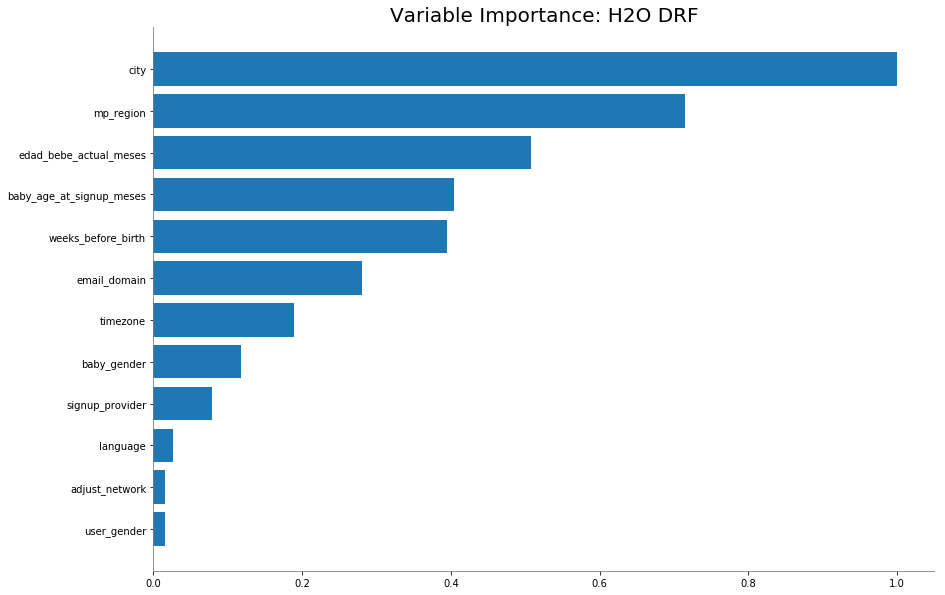

In [73]:
model.varimp_plot(num_of_features=15)

In [74]:
roc = model.model_performance(test_data=test, train=train)

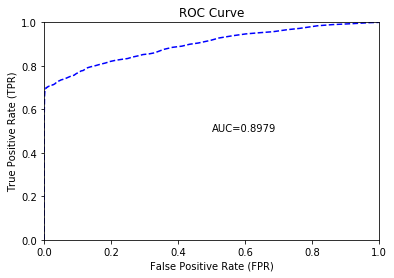

In [75]:
roc.plot()

In [ ]:
X_hf.col_names